In [1]:
## Notebook env: infercnv_env (R kernel)
## This notebook runs infercnv on miR or tRF data (depending on nb)
## try this script without regressing out variables (total UMI and mito pct) from data first
library(stringr)
library(Matrix)
library(infercnv)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(tidyr)
library(dplyr)
library(reshape2)
library(tibble)
library(ComplexHeatmap)
library(gridExtra)


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an int

## Running InferCNV on raw count matrix

In [2]:
## metadata
meta = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_meta.csv', row.names = 1)

## You will need to sample "normal" cells from all 19 controls
## do this by annotating all 19 controls as 1 and infercnv will sample from it
meta$guide <- gsub('-', '_', meta$guide)
meta$guide[str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'

head(meta)

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
miR_1:AAACCCAAGGAGAGGC-1,miR_1,AAACCCAAGGAGAGGC,hsa_miR_203a_3p,5.453121,2.983000e-159,3.010603e-152,67,78,0.1964736,11.324937,1.826075,1.892095,-0.7066959
miR_1:AAACCCAAGGTAAACT-1,miR_1,AAACCCAAGGTAAACT,hsa_miR_93_3p,6.012001,3.907611e-225,3.943769e-218,97,108,0.2720403,23.713686,1.986772,2.033424,-0.5653668
miR_1:AAACCCACAACGATCT-1,miR_1,AAACCCACAACGATCT,hsa_miR_130b_3p,5.864701,3.299362e-202,3.329893e-195,89,113,0.2846348,19.981910,1.949390,2.053078,-0.5457121
miR_1:AAACCCACACGATTCA-1,miR_1,AAACCCACACGATTCA,TuD_NC,5.859895,2.574602e-201,2.598426e-194,96,114,0.2871537,23.235516,1.982271,2.056905,-0.5418857
miR_1:AAACCCACAGTCAACT-1,miR_1,AAACCCACAGTCAACT,hsa_miR_147b_5p,5.632808,3.564463e-178,3.597446e-171,71,86,0.2166247,12.725683,1.851258,1.934498,-0.6642921
miR_1:AAACCCACATCTCATT-1,miR_1,AAACCCACATCTCATT,hsa_miR_501_5p,5.261722,7.493882e-143,7.563226e-136,58,64,0.1612091,8.484047,1.763428,1.806180,-0.7926105


In [3]:
print(paste('barcodes =', length(unique(meta$barcode))))
print(paste('batched barcodes in rownames =', length(unique(rownames(meta)))))
print(paste('# of rows in metadata =', nrow(meta)))

[1] "barcodes = 29955"
[1] "batched barcodes in rownames = 30035"
[1] "# of rows in metadata = 30035"


In [5]:
## given that barcodes aren't completely unique (some are same across batches)
## use rownames for unique barcodes
## InferCNV will sample cells from all 3 batches since we've made no distinction in sample name for batches

## to deal with tRFs batch effects, 
## advice on github is to use seurat integration as preprocessing
## before feeding in data to infercnv

infercnv_meta = data.frame(rownames(meta), meta$guide)
colnames(infercnv_meta) = NULL
rownames(infercnv_meta) = NULL



In [6]:
head(infercnv_meta)

1,miR_1:AAACCCAAGGAGAGGC-1,hsa_miR_203a_3p
2,miR_1:AAACCCAAGGTAAACT-1,hsa_miR_93_3p
3,miR_1:AAACCCACAACGATCT-1,hsa_miR_130b_3p
4,miR_1:AAACCCACACGATTCA-1,TuD_NC
5,miR_1:AAACCCACAGTCAACT-1,hsa_miR_147b_5p
6,miR_1:AAACCCACATCTCATT-1,hsa_miR_501_5p


In [7]:
## save meta and rawdata (as a matrix? or sparsematrix?) for InferCNV_miR_execution_file.R

file_path = '/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw.mtx'
raw = readMM(file_path)

gene_names = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_genes.csv', header = FALSE)
gene_names = gene_names$V1

write.table(infercnv_meta, file = '/home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv_meta.txt', sep = '\t', row.names = FALSE, quote = FALSE)
raw = t(raw)
raw = as(raw, "dgCMatrix")
colnames(raw) <- rownames(meta)
rownames(raw) <- gene_names

infercnv_obj = CreateInfercnvObject(raw_counts_matrix = raw,
                                    annotations_file = '/home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv_meta.txt',
                                    delim="\t",
                                    gene_order_file = '/home/ssobti/projects/mir_tud/uploaded_data/infercnv/gencode_v19_gene_pos.txt',
                                    ref_group_names = 'TuD_NC') 


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



INFO [2022-11-21 11:38:18] Parsing gene order file: /home/ssobti/projects/mir_tud/uploaded_data/infercnv/gencode_v19_gene_pos.txt
INFO [2022-11-21 11:38:18] Parsing cell annotations file: /home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv_meta.txt
INFO [2022-11-21 11:38:18] ::order_reduce:Start.
INFO [2022-11-21 11:38:22] .order_reduce(): expr and order match.
INFO [2022-11-21 11:38:45] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 36601,30035 Total=1322209877 Min=0 Max=7510.
INFO [2022-11-21 11:38:47] num genes removed taking into account provided gene ordering list: 15701 = 42.8977350345619% removed.
INFO [2022-11-21 11:38:47] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2022-11-21 11:38:54] Please use "options(scipen = 100)" before running infercnv if you are using the analysis_mode="subclusters" option or you may encounter an error while the hclust is being generated.
INFO [2022-11-21 11:39:03] validating infercn

In [ ]:
infercnv_obj = infercnv::run(infercnv_obj,
                             cutoff = 0.1, # cutoff=1 works well for Smart-seq2, and cutoff=0.1 works well for 10x Genomics
                             out_dir = '/home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv', 
                             cluster_by_groups = TRUE, 
                             denoise = TRUE,
                             num_threads = 10,
                             output_format = 'pdf',
                             HMM = FALSE)

In [3]:
final_obj <- readRDS('/home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv/run.final.infercnv_obj')

In [ ]:
##plot_per_group(infercnv_obj = final_obj, output_format = 'pdf', base_filename = 'infercnv_by_group', out_dir = '/home/ssobti/projects/mir_tud/output_data/infercnv/miR_infercnv')

## Quantifying amount of Copy Number Variation per guide

In [5]:
CNV_mtx = final_obj@expr.data
CNV_mtx[1:3,1:3]

,miR_1:AAACCCAAGGAGAGGC-1,miR_1:AAACCCAAGGTAAACT-1,miR_1:AAACCCACAACGATCT-1
NOC2L,1.002876,1.002876,1.002876
PLEKHN1,1.002876,1.002876,1.002876
ISG15,1.002876,1.002876,1.002876


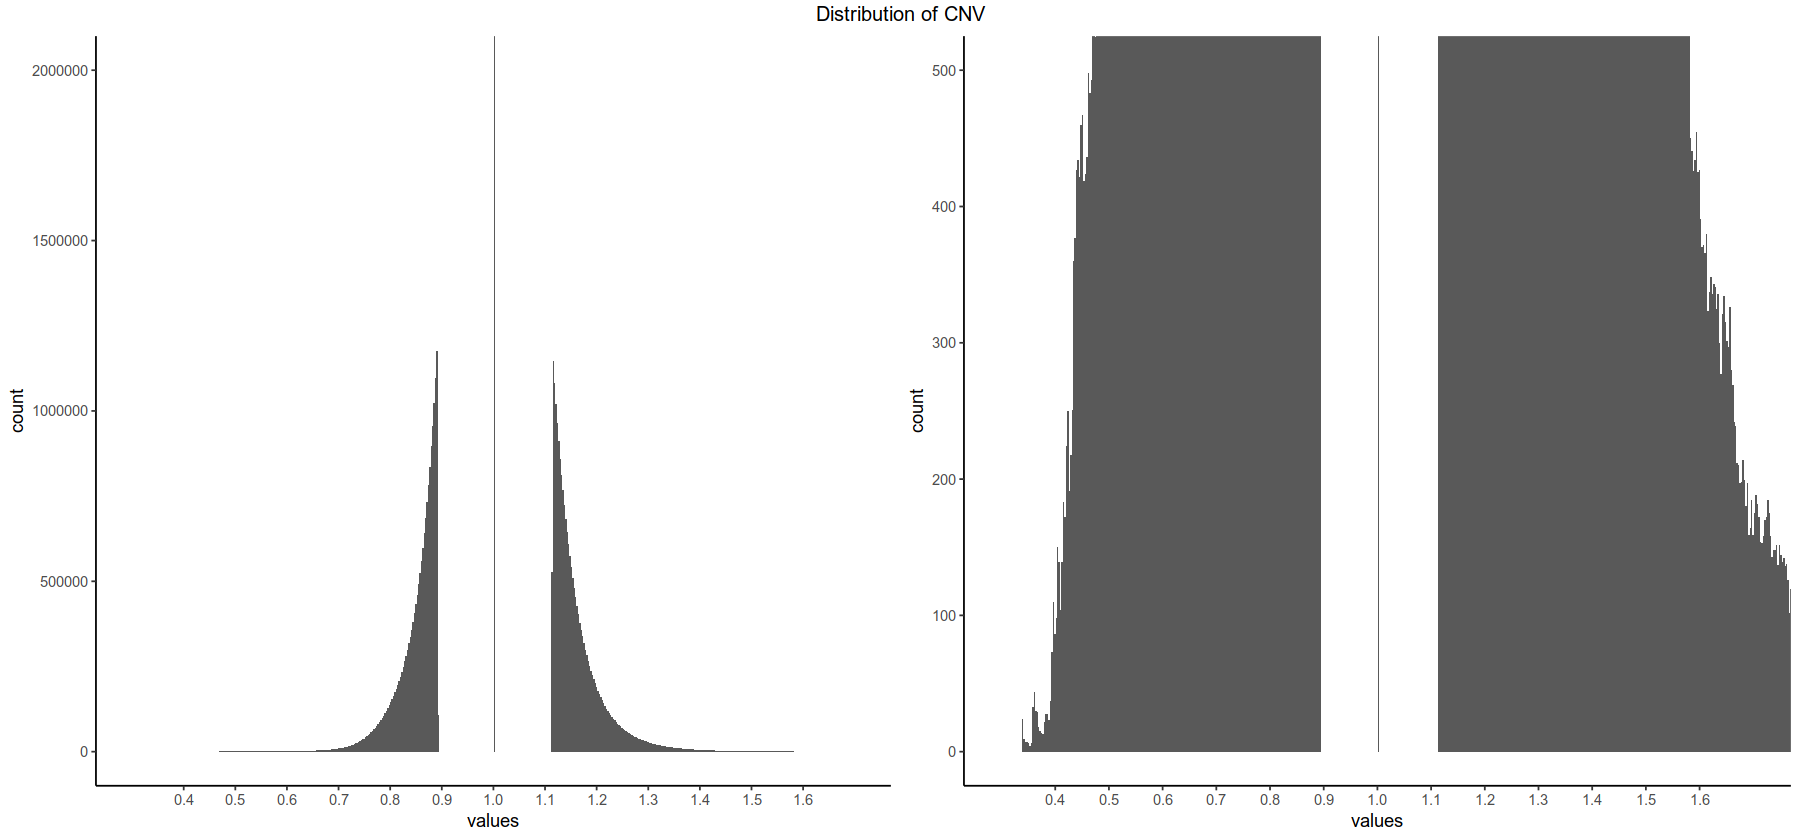

In [23]:
## Distribution of CNV values in InferCNV output matrix
## most of the values in the output matrix are 1 indicating normal gene expression 
## (the ceiling_view graph is capped much lower than the actual ceiling of the values at 1.0)

df = data.frame(values = as.numeric(CNV_mtx))

ceiling_view = ggplot(df, aes(x = values)) + 
geom_histogram(bins = 1000) + coord_cartesian(ylim = c(0, 2000000), xlim = c(0.3, 1.7)) + 
scale_x_continuous(breaks = seq(0.4, 1.6, length.out = 13)) + 
theme(plot.title = element_text(hjust = 0.5)) + theme_classic()

floor_view = ggplot(df, aes(x = values)) + 
geom_histogram(bins = 1000) + coord_cartesian(ylim = c(0, 500), xlim = c(0.3, 1.7)) + 
scale_x_continuous(breaks = seq(0.4, 1.6, length.out = 13)) + 
theme(plot.title = element_text(hjust = 0.5)) + theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
annotate_figure(ggarrange(ceiling_view, floor_view), top = text_grob("Distribution of CNV"))

In [6]:
## we can safely use 0.9 and 1.1 as cutoffs for deletions and amplifications
## we would now like to count the number of deletions and amplifications (ie exp <0.9 or >1.1) per cell 
CNV_counts = data.frame(cell = colnames(CNV_mtx), guide = meta$guide, CNV_count = rep(0, length(colnames(CNV_mtx))))
counter_func <- function(x){length(which(x < 0.9 | x > 1.1))}
CNV_counts$CNV_count = as.numeric(apply(X = CNV_mtx, MARGIN = 2, FUN = counter_func))

head(CNV_counts)

,cell,guide,CNV_count
,<chr>,<chr>,<dbl>
1,miR_1:AAACCCAAGGAGAGGC-1,hsa_miR_203a_3p,1358
2,miR_1:AAACCCAAGGTAAACT-1,hsa_miR_93_3p,1457
3,miR_1:AAACCCACAACGATCT-1,hsa_miR_130b_3p,1331
4,miR_1:AAACCCACACGATTCA-1,TuD_NC,1963
5,miR_1:AAACCCACAGTCAACT-1,hsa_miR_147b_5p,2244
6,miR_1:AAACCCACATCTCATT-1,hsa_miR_501_5p,1010


In [7]:
Guide_CNV_counts = CNV_counts %>% group_by(guide) %>% summarize(mean_cnv = mean(CNV_count), stdev = sd(CNV_count))
Guide_CNV_counts = Guide_CNV_counts %>% arrange(mean_cnv)
head(Guide_CNV_counts)

guide,mean_cnv,stdev
<chr>,<dbl>,<dbl>
hsa_miR_3613_5p,920.6364,384.3647
hsa_miR_15b_5p,1074.0000,609.2134
hsa_let_7a_5p,1085.1111,571.2286
hsa_miR_186_5p,1085.4783,484.9343
hsa_miR_221_3p,1103.3846,598.5390
hsa_miR_4742_3p,1135.4118,486.9658


## Mean CNV count with STDEV per guide

Warning message:
“ggrepel: 375 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


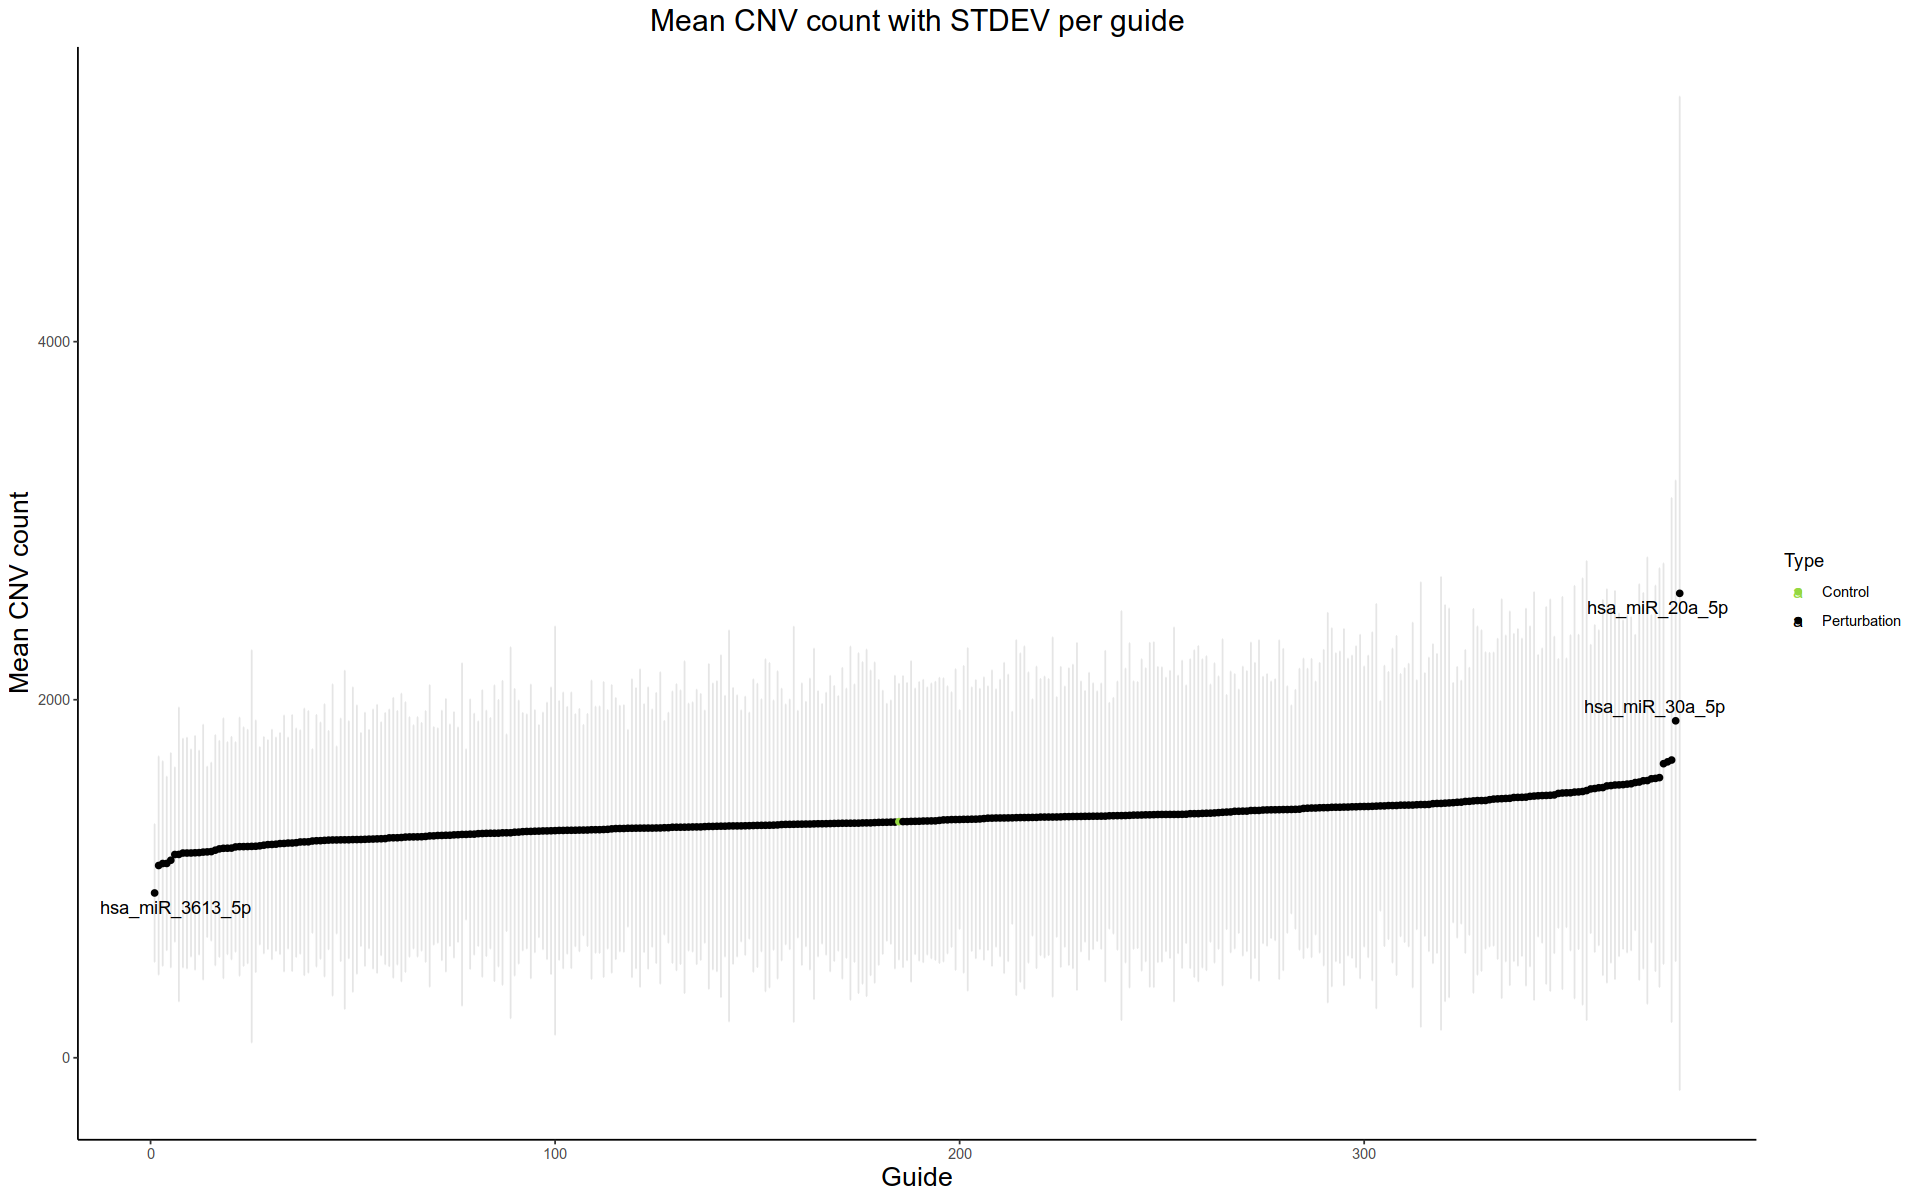

In [8]:
options(repr.plot.width = 16, repr.plot.height = 10)
controls = startsWith(Guide_CNV_counts$guide, 'TuD_NC')

cols = rep(0, nrow(Guide_CNV_counts))
cols[controls] = 'Control'
cols[!controls] = 'Perturbation'

Guide_CNV_counts$Type = cols
ggplot(Guide_CNV_counts, aes(x = 1:nrow(Guide_CNV_counts), y = mean_cnv, label = guide, color = Type)) + 
geom_errorbar(aes(ymin = mean_cnv - stdev, ymax = mean_cnv + stdev), color = 'grey90', width = .2, 
                             position = position_dodge(0.05)) + 
geom_point() + theme_classic() + xlab('Guide') + ylab('Mean CNV count') +
geom_text_repel() + ggtitle('Mean CNV count with STDEV per guide') + scale_color_manual(values = c("Perturbation" = "black", "Control" = "#95D840FF")) +
theme(plot.title = element_text(hjust = 0.5, size = 18), axis.title.x = element_text(size = 16), axis.title.y = element_text(size = 16))


## Find distances between perturbations (median Hamming distance between cells of each guide)

In [ ]:
## use hamming distance for clustered pairwise distance heatmap of guide CNV profiles
## also can just cluster CNV matrix by 'avg cell' of each guide

In [9]:
## hamming distance calculation
CNV_mtx_hammed = CNV_mtx
CNV_mtx_hammed[CNV_mtx < 0.9 | CNV_mtx > 1.1] = 1
CNV_mtx_hammed[!(CNV_mtx < 0.9 | CNV_mtx > 1.1)] = 0

hamming <- function(mtx) {
    D <- (1 - mtx) %*% t(mtx)
    D + t(D)
}
hamming_distances = hamming(t(CNV_mtx_hammed))
hamming_distances[1:3,1:3]

,miR_1:AAACCCAAGGAGAGGC-1,miR_1:AAACCCAAGGTAAACT-1,miR_1:AAACCCACAACGATCT-1
miR_1:AAACCCAAGGAGAGGC-1,0,2229,2393
miR_1:AAACCCAAGGTAAACT-1,2229,0,2138
miR_1:AAACCCACAACGATCT-1,2393,2138,0


In [10]:
guides = unique(meta$guide)
median_hm_dist = cbind(as.data.frame(crossing(guides, guides)), median_distance = 0)
colnames(median_hm_dist)[1:2] <- c('guide1', 'guide2')
head(median_hm_dist)

,guide1,guide2,median_distance
,<chr>,<chr>,<dbl>
1,hsa_let_7a_2_3p,hsa_let_7a_2_3p,0
2,hsa_let_7a_2_3p,hsa_let_7a_5p,0
3,hsa_let_7a_2_3p,hsa_let_7b_3p,0
4,hsa_let_7a_2_3p,hsa_let_7d_3p,0
5,hsa_let_7a_2_3p,hsa_let_7f_2_3p,0
6,hsa_let_7a_2_3p,hsa_let_7i_3p,0


In [11]:
## get distribution of hamming distances between cells of guide A and cells of guide B
## calculate median hamming distance between cells of each guide
pb = txtProgressBar(min = 0, max = nrow(median_hm_dist), initial = 0, style = 3) 
for (i in 1:nrow(median_hm_dist)){
    cellsA <- which(meta$guide == as.character(median_hm_dist[i,1]))
    cellsB <- which(meta$guide == as.character(median_hm_dist[i,2]))
    median_hm_dist[i,3] = median(hamming_distances[c(cellsA, cellsB), c(cellsA, cellsB)][(length(cellsA)+1):(length(cellsA) + length(cellsB)), 1:length(cellsA)])
    setTxtProgressBar(pb,i)
    close(pb)
}

  |                                                                      |   0%
  |======================================================================| 100%

In [12]:
median_hm_dist_mtx = pivot_wider(as.data.frame(median_hm_dist), names_from = guide2, values_from = median_distance) %>% 
column_to_rownames(var="guide1")
median_hm_dist_mtx = as.matrix(median_hm_dist_mtx)
median_hm_dist_mtx

,hsa_let_7a_2_3p,hsa_let_7a_5p,hsa_let_7b_3p,hsa_let_7d_3p,hsa_let_7f_2_3p,hsa_let_7i_3p,hsa_let_7i_5p,hsa_miR_100_3p,hsa_miR_100_5p,hsa_miR_101_3p,⋯,hsa_miR_941,hsa_miR_942_3p,hsa_miR_942_5p,hsa_miR_95_3p,hsa_miR_96_5p,hsa_miR_98_3p,hsa_miR_9903,hsa_miR_99b_3p,hsa_miR_99b_5p,TuD_NC
hsa_let_7a_2_3p,2136.5,1973.0,2150.5,2209.5,2254.5,2201.0,2248.0,2044.0,2268.0,2136.5,⋯,2063.5,2122.0,2225.0,2127.5,2068.0,2139.5,2220.5,2138.0,2220.0,2153
hsa_let_7a_5p,1973.0,1675.0,1980.0,2030.5,2092.0,2034.0,2102.0,1847.5,2132.0,1989.0,⋯,1878.0,1975.0,2064.0,1913.0,1891.0,2006.0,2049.5,1943.0,2038.0,1980
hsa_let_7b_3p,2150.5,1980.0,2137.0,2215.0,2264.5,2194.0,2251.5,2048.5,2258.5,2144.0,⋯,2059.5,2127.0,2244.5,2137.0,2063.0,2158.0,2239.0,2149.0,2221.0,2157
hsa_let_7d_3p,2209.5,2030.5,2215.0,2240.0,2301.5,2247.0,2308.5,2105.0,2331.0,2200.5,⋯,2121.5,2170.5,2268.5,2180.5,2131.0,2203.5,2259.5,2177.5,2278.0,2209
hsa_let_7f_2_3p,2254.5,2092.0,2264.5,2301.5,2354.0,2297.0,2350.0,2151.5,2335.0,2248.0,⋯,2181.0,2230.0,2345.0,2240.0,2175.0,2253.0,2324.0,2245.0,2330.0,2258
hsa_let_7i_3p,2201.0,2034.0,2194.0,2247.0,2297.0,2211.0,2266.0,2097.5,2283.0,2188.0,⋯,2103.0,2160.0,2281.5,2161.0,2116.0,2189.0,2254.5,2175.0,2255.0,2194
hsa_let_7i_5p,2248.0,2102.0,2251.5,2308.5,2350.0,2266.0,2285.0,2158.0,2344.0,2238.0,⋯,2169.0,2231.0,2323.0,2240.0,2179.5,2249.0,2310.0,2233.0,2319.0,2249
hsa_miR_100_3p,2044.0,1847.5,2048.5,2105.0,2151.5,2097.5,2158.0,1921.0,2178.0,2035.0,⋯,1955.0,2027.0,2125.0,2017.0,1965.0,2060.0,2123.0,2039.5,2112.0,2056
hsa_miR_100_5p,2268.0,2132.0,2258.5,2331.0,2335.0,2283.0,2344.0,2178.0,2327.0,2247.5,⋯,2159.5,2241.0,2320.0,2209.5,2175.5,2247.0,2311.5,2251.5,2313.0,2261
hsa_miR_101_3p,2136.5,1989.0,2144.0,2200.5,2248.0,2188.0,2238.0,2035.0,2247.5,2139.0,⋯,2059.0,2124.0,2225.5,2123.0,2065.0,2147.0,2229.0,2142.0,2218.5,2152


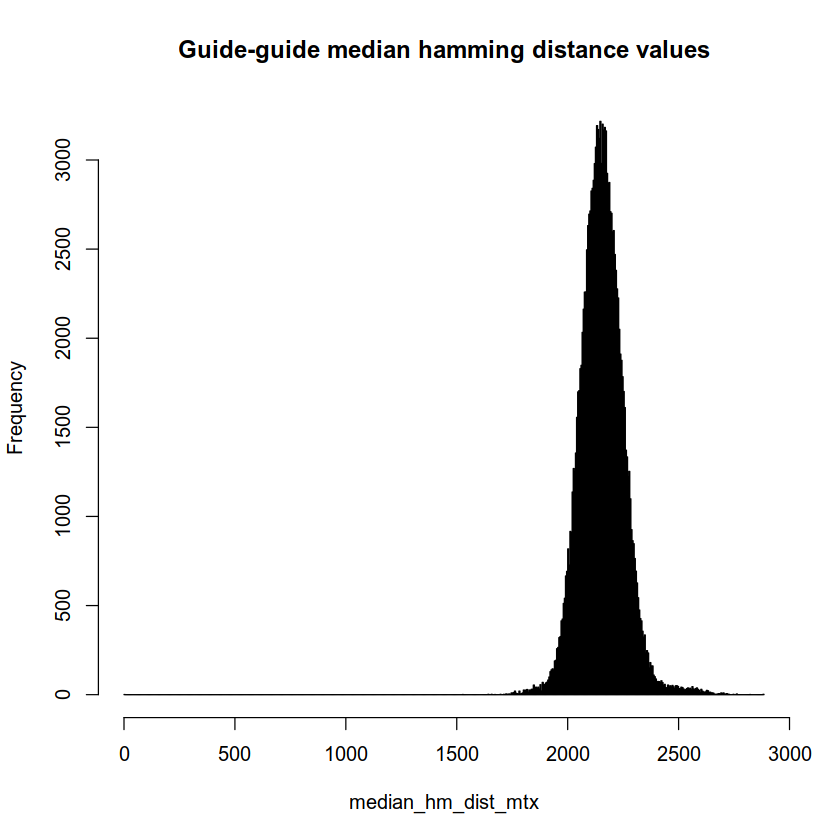

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist(median_hm_dist_mtx, breaks = 1000, main = 'Guide-guide median hamming distance values')

## Clustering guides by hamming distance of CNV profiles 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



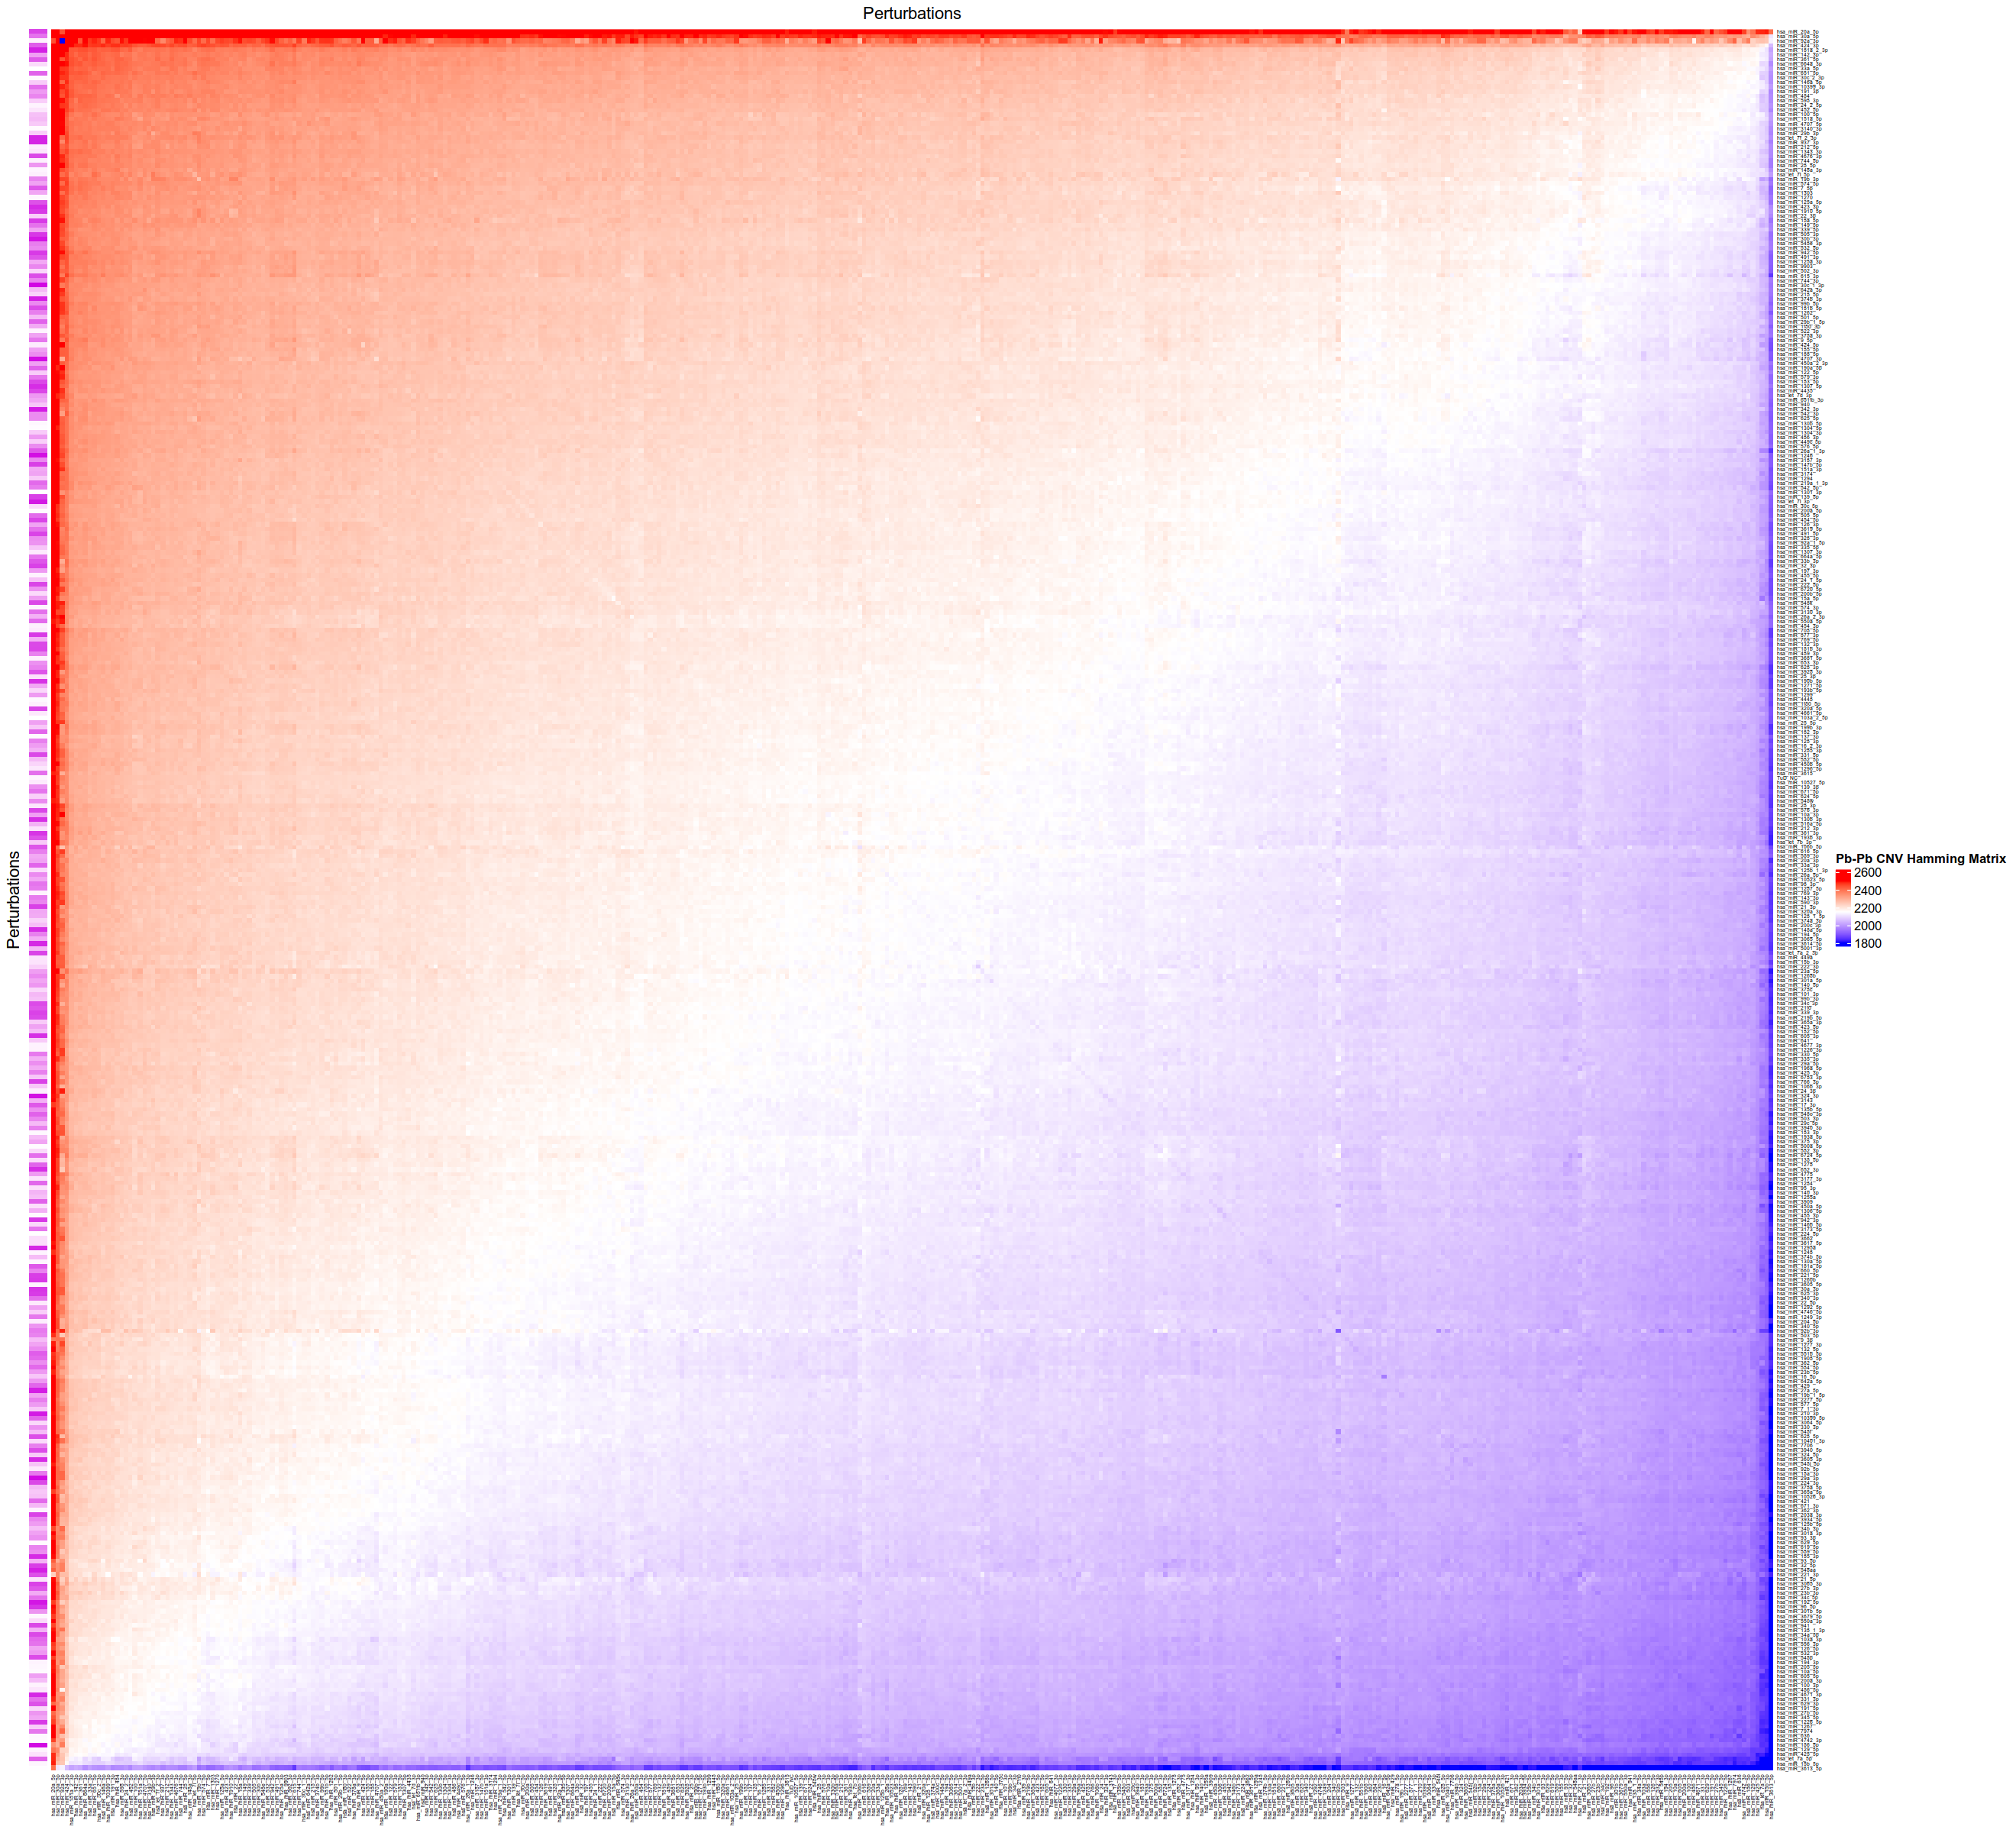

In [14]:
## heatmap of median between all possible guide pairs
set.seed(20)
coloring_map <- circlize::colorRamp2(c(1804, 2152, 2500), c("blue", "white", "red"))

annot = rowAnnotation(perturb = runif(nrow(median_hm_dist_mtx)), show_legend = FALSE, show_annotation_name = FALSE)

perturb_perturb_mtx_htmp <- function(matrix, title, annotation) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 4), row_names_gp = gpar(fontsize = 4),
               left_annotation = annotation))
}


options(repr.plot.width = 22, repr.plot.height = 20)
perturb_perturb_mtx_htmp(median_hm_dist_mtx, 'Pb-Pb CNV Hamming Matrix', annot)

## Find correlations between averaged CNV profiles of guides

In [15]:
## avg the cells in CNV expression mtx by guide
guides = unique(meta$guide)
avg_guide_exp = matrix(0, nrow = nrow(CNV_mtx), ncol = length(guides), dimnames = list(rownames(CNV_mtx), guides))

for (i in 1:length(guides)){
    cells <- meta$guide == guides[i]
    if (length(which(cells)) == 1) {
        avg_guide_exp[,i] = CNV_mtx[,cells]
    } else {
        avg_guide_exp[,i] <- rowMeans(CNV_mtx[,cells])
    } 
}

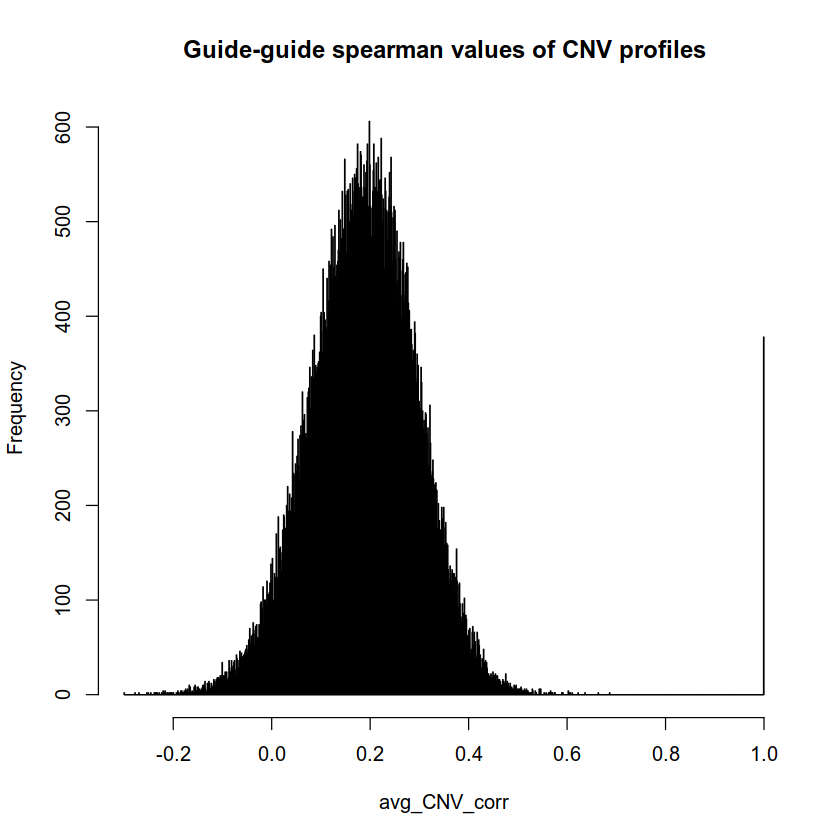

In [16]:
avg_CNV_corr = cor(avg_guide_exp, method = 'spearman')
options(repr.plot.width = 7, repr.plot.height = 7)
hist(avg_CNV_corr, breaks = 1000, main = 'Guide-guide spearman values of guide-averaged CNV profiles')

In [24]:
print(mean(avg_CNV_corr))
print(mean(avg_CNV_corr) - 2*sd(avg_CNV_corr))
print(mean(avg_CNV_corr) + 2*sd(avg_CNV_corr))

[1] 0.1888286
[1] -0.03816178
[1] 0.4158191


## Correlation matrix of guide-guide average CNV profiles ie which guide-averaged CNV profile is closest to another

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



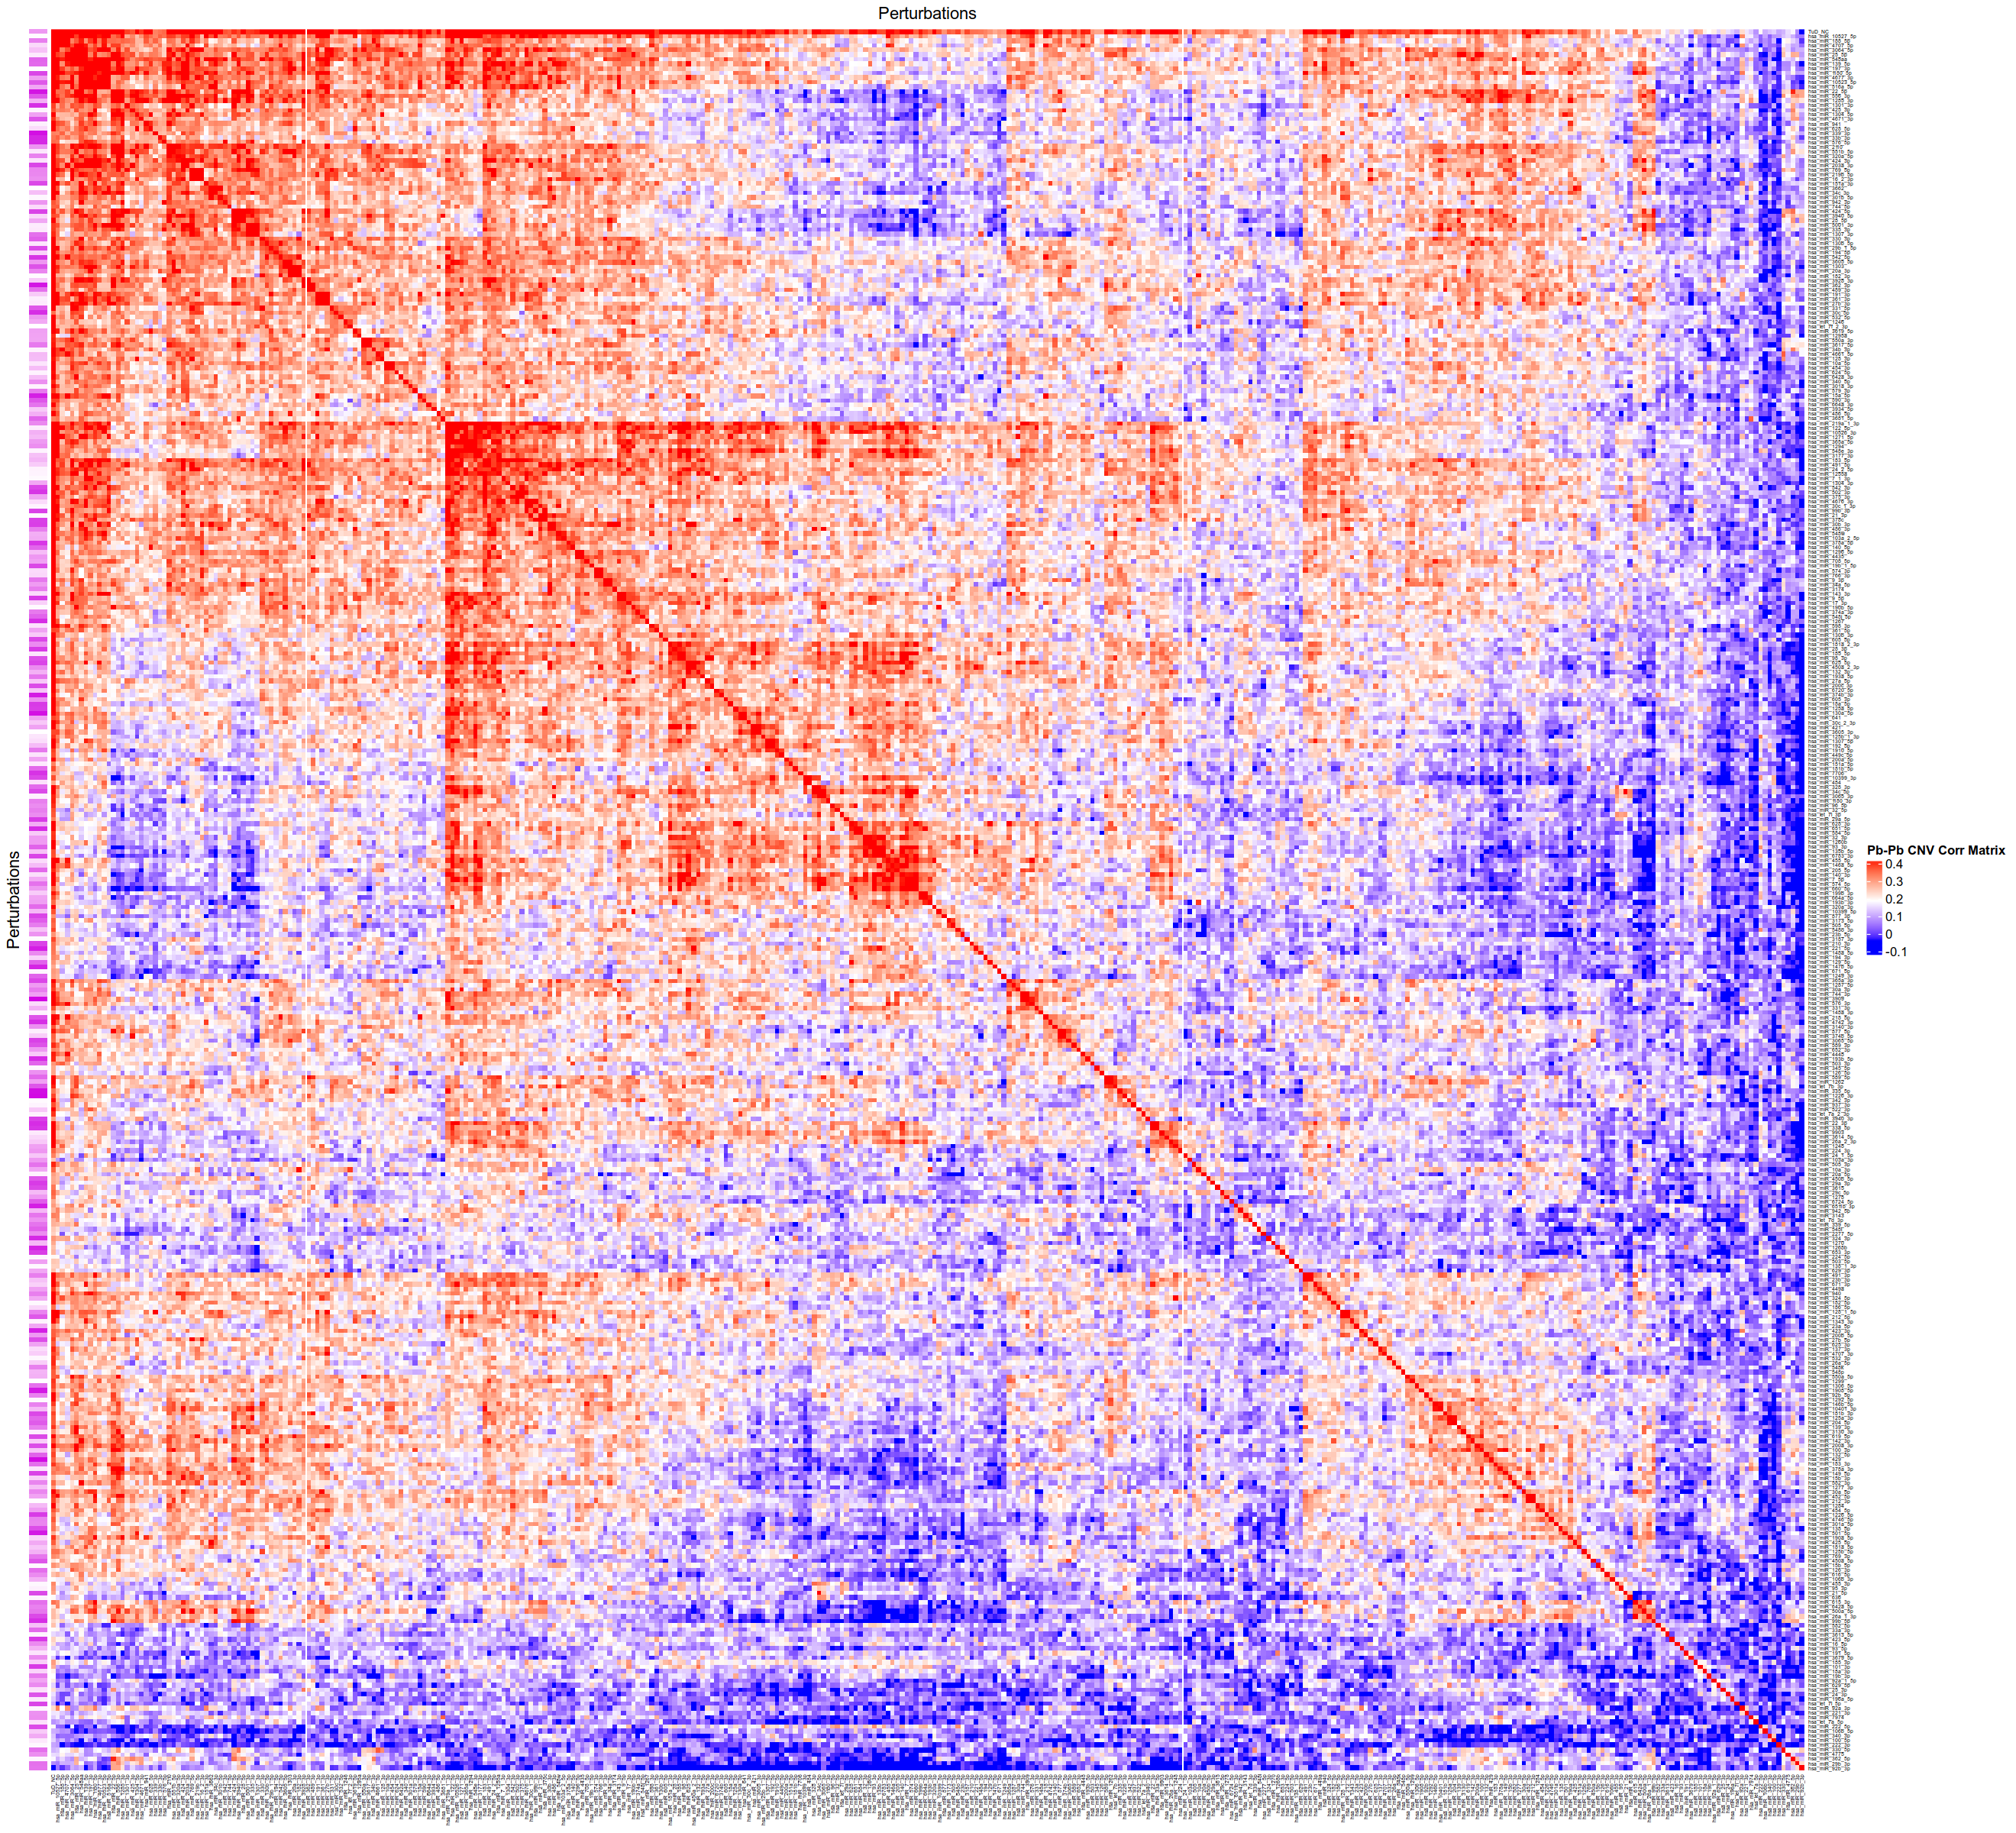

In [26]:
## heatmap of median correlation between all possible guide pairs
set.seed(20)
avg = mean(avg_CNV_corr)
lower_bound = mean(avg_CNV_corr) - 2*sd(avg_CNV_corr)
upper_bound = mean(avg_CNV_corr) + 2*sd(avg_CNV_corr)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

annot = rowAnnotation(perturb = runif(nrow(avg_CNV_corr)), show_legend = FALSE, show_annotation_name = FALSE)

perturb_perturb_mtx_htmp <- function(matrix, title, annotation) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 4), row_names_gp = gpar(fontsize = 4),
               left_annotation = annotation))
}


options(repr.plot.width = 22, repr.plot.height = 20)
perturb_perturb_mtx_htmp(avg_CNV_corr, 'Pb-Pb CNV Corr Matrix', annot)